<a href="https://colab.research.google.com/github/ptl-harsh/DL_Lab/blob/main/DL_Lab02_07_August.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =======================
# Google Colab: ANN on Iris (ReLU vs tanh)
# =======================

# Cell 1: installs (usually not needed on Colab) and imports
!pip install -q scikit-learn pandas matplotlib tensorflow

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Reproducibility (best-effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Cell 2: load & preprocess data
iris = load_iris()
X = iris.data            # shape (150, 4)
y = iris.target          # integer labels 0,1,2
target_names = iris.target_names.tolist()

# Train-test split: 70% train, 30% test (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

# Standardize features (important for ANNs)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Convert labels to categorical for Keras
y_train_cat = utils.to_categorical(y_train, num_classes=3)
y_test_cat  = utils.to_categorical(y_test, num_classes=3)

In [4]:

# Cell 3: helper to build model
def build_ann(input_dim, hidden_units=10, hidden_activation="relu", lr=1e-3):
    """
    Simple feedforward ANN:
      - Dense(hidden_units, activation=hidden_activation)
      - Dense(3, activation='softmax')
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units, activation=hidden_activation, name="hidden"),
        layers.Dense(3, activation="softmax", name="output")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [5]:
# Cell 4: training settings
EPOCHS = 200
BATCH_SIZE = 16
PATIENCE = 15  # early stopping patience

es_cb = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=1)

# Directory to save outputs
OUTDIR = "/content/ann_iris_outputs_colab"
os.makedirs(OUTDIR, exist_ok=True)

In [6]:
# Cell 5: build, train and evaluate both models
models_info = []
for act in ["relu", "tanh"]:
    print("\n" + "="*60)
    print(f"Training ANN with hidden activation = {act}")
    print("="*60)

    model = build_ann(input_dim=X_train_s.shape[1], hidden_units=10, hidden_activation=act, lr=1e-3)
    history = model.fit(
        X_train_s, y_train_cat,
        validation_split=0.15,   # small validation split from train
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es_cb],
        verbose=1
    )
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test_s, y_test_cat, verbose=0)
    print(f"\nTest accuracy (activation={act}): {test_acc:.4f}    Test loss: {test_loss:.4f}")

    # Predictions (class labels)
    y_proba = model.predict(X_test_s)
    y_pred = np.argmax(y_proba, axis=1)

    # Metrics: classification report & confusion matrix
    creport = classification_report(y_test, y_pred, target_names=target_names, digits=4)
    cm = confusion_matrix(y_test, y_pred)

    print("\nClassification report:\n")
    print(creport)
    print("Confusion matrix:\n", cm)

    # Save model and history summary
    model_file = os.path.join(OUTDIR, f"ann_{act}.h5")
    model.save(model_file)

    hist_df = pd.DataFrame(history.history)
    hist_csv = os.path.join(OUTDIR, f"history_{act}.csv")
    hist_df.to_csv(hist_csv, index=False)

    # Save summary info
    models_info.append({
        "activation": act,
        "model_file": model_file,
        "test_accuracy": float(test_acc),
        "test_loss": float(test_loss),
        "history_csv": hist_csv,
        "classification_report": creport,
        "confusion_matrix": cm.tolist()
    })


Training ANN with hidden activation = relu
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1790 - loss: 1.4779 - val_accuracy: 0.2500 - val_loss: 1.3312
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1554 - loss: 1.4296 - val_accuracy: 0.2500 - val_loss: 1.2946
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1482 - loss: 1.3831 - val_accuracy: 0.2500 - val_loss: 1.2587
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1532 - loss: 1.3375 - val_accuracy: 0.1875 - val_loss: 1.2236
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1296 - loss: 1.2932 - val_accuracy: 0.1875 - val_loss: 1.1895
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1750 - loss: 1.2502 - val_accuracy: 0.2500 - val_loss: 1.1566
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1706 - loss: 1.2087 - val_accuracy: 0.1875 - val_loss: 1.1248
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2504 - los


Classification report:

              precision    recall  f1-score   support

      setosa     1.0000    1.0000    1.0000        15
  versicolor     0.8571    0.8000    0.8276        15
   virginica     0.8125    0.8667    0.8387        15

    accuracy                         0.8889        45
   macro avg     0.8899    0.8889    0.8888        45
weighted avg     0.8899    0.8889    0.8888        45

Confusion matrix:
 [[15  0  0]
 [ 0 12  3]
 [ 0  2 13]]

Training ANN with hidden activation = tanh
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3512 - loss: 1.0792 - val_accuracy: 0.2500 - val_loss: 1.0796
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4231 - loss: 1.0311 - val_accuracy: 0.3750 - val_loss: 1.0331
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4529 - loss: 0.9863 - val_accuracy: 0.3750 - val_loss: 0.9891
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5506 - loss: 0.9441 - val_accuracy: 0.4375 - val_los


Classification report:

              precision    recall  f1-score   support

      setosa     1.0000    1.0000    1.0000        15
  versicolor     0.8750    0.9333    0.9032        15
   virginica     0.9286    0.8667    0.8966        15

    accuracy                         0.9333        45
   macro avg     0.9345    0.9333    0.9333        45
weighted avg     0.9345    0.9333    0.9333        45

Confusion matrix:
 [[15  0  0]
 [ 0 14  1]
 [ 0  2 13]]


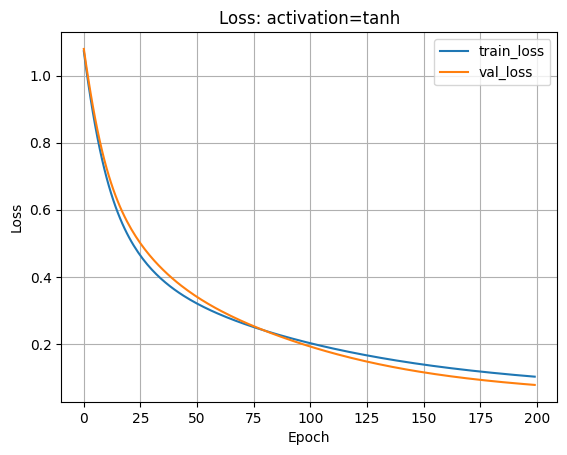

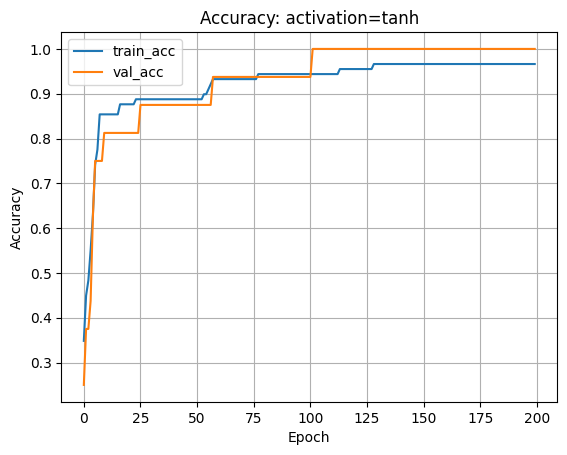

In [7]:

    # Cell 6 (inside loop): plot loss and accuracy for this model (each plot separate)
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"Loss: activation={act}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"Accuracy: activation={act}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:

# Cell 7: summary table + save summary CSV
summary_df = pd.DataFrame([{
    "Activation": info["activation"],
    "Test accuracy": round(info["test_accuracy"], 4),
    "Test loss": round(info["test_loss"], 4),
    "Model file": info["model_file"],
    "History csv": info["history_csv"]
} for info in models_info])

print("\n=== Summary ===\n")
print(summary_df.to_string(index=False))

summary_csv = os.path.join(OUTDIR, "summary_results.csv")
summary_df.to_csv(summary_csv, index=False)
print(f"\nSaved outputs to: {OUTDIR}")
print(f" - summary CSV: {summary_csv}")
for info in models_info:
    print(f" - model ({info['activation']}): {info['model_file']}")


=== Summary ===

Activation  Test accuracy  Test loss                                  Model file                                      History csv
      relu         0.8889     0.2763 /content/ann_iris_outputs_colab/ann_relu.h5 /content/ann_iris_outputs_colab/history_relu.csv
      tanh         0.9333     0.1670 /content/ann_iris_outputs_colab/ann_tanh.h5 /content/ann_iris_outputs_colab/history_tanh.csv

Saved outputs to: /content/ann_iris_outputs_colab
 - summary CSV: /content/ann_iris_outputs_colab/summary_results.csv
 - model (relu): /content/ann_iris_outputs_colab/ann_relu.h5
 - model (tanh): /content/ann_iris_outputs_colab/ann_tanh.h5


In [9]:
# Cell 8: (optional) print stored classification reports & confusion matrices
for info in models_info:
    print("\n" + "-"*40)
    print(f"Activation = {info['activation']}")
    print("-"*40)
    print("Classification report:\n")
    print(info["classification_report"])
    print("Confusion matrix:")
    print(np.array(info["confusion_matrix"]))


----------------------------------------
Activation = relu
----------------------------------------
Classification report:

              precision    recall  f1-score   support

      setosa     1.0000    1.0000    1.0000        15
  versicolor     0.8571    0.8000    0.8276        15
   virginica     0.8125    0.8667    0.8387        15

    accuracy                         0.8889        45
   macro avg     0.8899    0.8889    0.8888        45
weighted avg     0.8899    0.8889    0.8888        45

Confusion matrix:
[[15  0  0]
 [ 0 12  3]
 [ 0  2 13]]

----------------------------------------
Activation = tanh
----------------------------------------
Classification report:

              precision    recall  f1-score   support

      setosa     1.0000    1.0000    1.0000        15
  versicolor     0.8750    0.9333    0.9032        15
   virginica     0.9286    0.8667    0.8966        15

    accuracy                         0.9333        45
   macro avg     0.9345    0.9333    0.933